# Group Comparisons Analysis (RQ2)

**Research Question 2:** How do ethical concerns about ChatGPT vary by usage frequency, discipline, and demographics?

**Team:** Team 5  
**Date:** November 2025

---

## Analysis Overview

This notebook examines variation in ethical concerns across:

1. **Usage Frequency** (Daily, Weekly, Monthly)
2. **Discipline** (Arts & Humanities, Social Sciences, Applied Sciences, Natural & Life Sciences)
3. **Demographics:**
   - Gender (Male, Female, Other, Prefer not to say)
   - Age Groups (18-21, 22-25, 26-30, 31+)
   - Study Level (Undergraduate, Postgraduate/Masters, Doctoral)
   - Region/Language (EN, ES, AR, TR, IT, JP, HE)

## 1. Setup and Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, ttest_ind, kruskal, levene
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.float_format', '{:.3f}'.format)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

# Output directories
output_dir = Path('results/tables')
fig_dir = Path('results/figures')
output_dir.mkdir(parents=True, exist_ok=True)
fig_dir.mkdir(parents=True, exist_ok=True)

print("✅ Libraries loaded")

✅ Libraries loaded


In [2]:
# Load data
df = pd.read_csv('../../data/cleaned/cleaned_data.csv', low_memory=False)
print(f"Loaded: {len(df):,} students")
print(f"Ethics concerns score available: {df['ethics_concerns_score'].notna().sum():,} responses")

Loaded: 22,836 students
Ethics concerns score available: 16,313 responses


In [3]:
# Create labeled variables based on questionnaire codebook

# Q10: Field of Study (Discipline)
discipline_map = {
    1: 'Arts & Humanities',
    2: 'Social Sciences',
    3: 'Applied Sciences',
    4: 'Natural & Life Sciences'
}
df['discipline'] = df['Q10'].map(discipline_map)

# Q2: Gender
gender_map = {
    1: 'Male',
    2: 'Female',
    3: 'Other',
    4: 'Prefer not to say'
}
df['gender'] = df['Q2'].map(gender_map)

# Q8: Study Level
level_map = {
    1: 'Undergraduate',
    2: 'Postgraduate/Masters',
    3: 'Doctoral'
}
df['study_level'] = df['Q8'].map(level_map)

# Q3: Age Groups
df['age_numeric'] = pd.to_numeric(df['Q3'], errors='coerce')
df['age_group'] = pd.cut(df['age_numeric'], 
                         bins=[17, 21, 25, 30, 100], 
                         labels=['18-21', '22-25', '26-30', '31+'])

# Region labels based on source language
region_map = {
    'EN': 'English',
    'ES': 'Spanish',
    'AR': 'Arabic',
    'TR': 'Turkish',
    'IT': 'Italian',
    'JP': 'Japanese',
    'HE': 'Hebrew'
}
df['region'] = df['source'].map(region_map)

print("✅ Variables created:")
print(f"   - discipline: {df['discipline'].notna().sum():,} valid")
print(f"   - gender: {df['gender'].notna().sum():,} valid")
print(f"   - study_level: {df['study_level'].notna().sum():,} valid")
print(f"   - age_group: {df['age_group'].notna().sum():,} valid")
print(f"   - region: {df['region'].notna().sum():,} valid")

✅ Variables created:
   - discipline: 22,243 valid
   - gender: 22,695 valid
   - study_level: 22,385 valid
   - age_group: 22,654 valid
   - region: 22,836 valid


## 2. Helper Functions

In [4]:
def run_anova_analysis(data, group_var, outcome_var='ethics_concerns_score', group_order=None):
    """
    Run complete ANOVA analysis with descriptives, test, and effect size.
    
    Parameters:
    -----------
    data : DataFrame
    group_var : str - column name for grouping variable
    outcome_var : str - column name for outcome variable
    group_order : list - optional ordering for groups
    
    Returns:
    --------
    dict with results
    """
    # Filter valid data
    valid_data = data[[group_var, outcome_var]].dropna()
    
    # Get groups
    groups = valid_data[group_var].unique()
    if group_order:
        groups = [g for g in group_order if g in groups]
    
    # Descriptive statistics
    desc_stats = valid_data.groupby(group_var)[outcome_var].agg(['count', 'mean', 'std']).round(3)
    desc_stats['se'] = (desc_stats['std'] / np.sqrt(desc_stats['count'])).round(3)
    if group_order:
        desc_stats = desc_stats.reindex(group_order)
    
    # Prepare groups for ANOVA
    group_data = [valid_data[valid_data[group_var] == g][outcome_var].values for g in groups]
    
    # Levene's test for homogeneity of variance
    levene_stat, levene_p = levene(*group_data)
    
    # One-way ANOVA
    f_stat, p_val = f_oneway(*group_data)
    
    # Effect size (eta-squared)
    grand_mean = valid_data[outcome_var].mean()
    ss_between = sum(len(g) * (np.mean(g) - grand_mean)**2 for g in group_data)
    ss_total = ((valid_data[outcome_var] - grand_mean)**2).sum()
    eta_squared = ss_between / ss_total
    
    # Interpret effect size
    if eta_squared < 0.01:
        effect_interp = 'Negligible'
    elif eta_squared < 0.06:
        effect_interp = 'Small'
    elif eta_squared < 0.14:
        effect_interp = 'Medium'
    else:
        effect_interp = 'Large'
    
    return {
        'descriptives': desc_stats,
        'f_stat': f_stat,
        'p_value': p_val,
        'eta_squared': eta_squared,
        'effect_interpretation': effect_interp,
        'levene_stat': levene_stat,
        'levene_p': levene_p,
        'n_total': len(valid_data),
        'groups': groups
    }


def print_anova_results(results, title):
    """Print formatted ANOVA results."""
    print("\n" + "="*80)
    print(f"ANOVA: {title}")
    print("="*80)
    
    print("\nDescriptive Statistics:")
    print(results['descriptives'].to_string())
    
    print(f"\nLevene's Test for Homogeneity of Variance:")
    print(f"  W = {results['levene_stat']:.4f}, p = {results['levene_p']:.4f}")
    if results['levene_p'] < 0.05:
        print("  ⚠️ Assumption of equal variances violated (consider Welch's ANOVA)")
    else:
        print("  ✅ Equal variances assumption met")
    
    print(f"\nOne-Way ANOVA:")
    print(f"  F = {results['f_stat']:.4f}")
    print(f"  p = {results['p_value']:.4e}")
    
    if results['p_value'] < 0.001:
        print("  ✅ Highly significant (p < 0.001)")
    elif results['p_value'] < 0.01:
        print("  ✅ Significant (p < 0.01)")
    elif results['p_value'] < 0.05:
        print("  ✅ Significant (p < 0.05)")
    else:
        print("  ❌ Not significant (p ≥ 0.05)")
    
    print(f"\nEffect Size:")
    print(f"  η² = {results['eta_squared']:.4f} ({results['effect_interpretation']} effect)")
    print(f"\nTotal N = {results['n_total']:,}")


def run_posthoc_tests(data, group_var, outcome_var='ethics_concerns_score', groups=None):
    """Run pairwise t-tests with Bonferroni correction."""
    valid_data = data[[group_var, outcome_var]].dropna()
    
    if groups is None:
        groups = valid_data[group_var].unique()
    
    results = []
    n_comparisons = len(groups) * (len(groups) - 1) // 2
    bonferroni_alpha = 0.05 / n_comparisons
    
    for i, g1 in enumerate(groups):
        for g2 in groups[i+1:]:
            data1 = valid_data[valid_data[group_var] == g1][outcome_var]
            data2 = valid_data[valid_data[group_var] == g2][outcome_var]
            
            t_stat, p_val = ttest_ind(data1, data2)
            
            # Cohen's d
            pooled_std = np.sqrt(((len(data1)-1)*data1.std()**2 + (len(data2)-1)*data2.std()**2) / 
                                 (len(data1) + len(data2) - 2))
            cohens_d = (data1.mean() - data2.mean()) / pooled_std
            
            results.append({
                'Comparison': f"{g1} vs {g2}",
                't': t_stat,
                'p': p_val,
                'p_adj': min(p_val * n_comparisons, 1.0),
                "Cohen's d": cohens_d,
                'Sig': '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else 'ns',
                'Sig_Bonf': '*' if p_val < bonferroni_alpha else 'ns'
            })
    
    return pd.DataFrame(results), bonferroni_alpha

print("✅ Helper functions defined")

✅ Helper functions defined


---

## 3. Ethical Concerns by Usage Frequency

Comparing ethical concerns across Daily, Weekly, and Monthly ChatGPT users.

In [5]:
# Run ANOVA for Usage Frequency
usage_order = ['Daily', 'Weekly', 'Monthly']
usage_results = run_anova_analysis(df, 'usage_label', group_order=usage_order)
print_anova_results(usage_results, 'Ethical Concerns by Usage Frequency')


ANOVA: Ethical Concerns by Usage Frequency

Descriptive Statistics:
             count  mean   std    se
usage_label                         
Daily        12576 3.343 0.738 0.007
Weekly        3079 3.321 0.757 0.014
Monthly        513 3.334 0.776 0.034

Levene's Test for Homogeneity of Variance:
  W = 1.4469, p = 0.2353
  ✅ Equal variances assumption met

One-Way ANOVA:
  F = 1.1240
  p = 3.2501e-01
  ❌ Not significant (p ≥ 0.05)

Effect Size:
  η² = 0.0001 (Negligible effect)

Total N = 16,168


In [6]:
# Post-hoc tests for Usage
if usage_results['p_value'] < 0.05:
    posthoc_usage, bonf_alpha = run_posthoc_tests(df, 'usage_label', groups=usage_order)
    print("\nPost-hoc Pairwise Comparisons:")
    print(f"(Bonferroni-corrected α = {bonf_alpha:.4f})")
    print(posthoc_usage.to_string(index=False))
else:
    print("\nPost-hoc tests not performed (ANOVA not significant)")


Post-hoc tests not performed (ANOVA not significant)


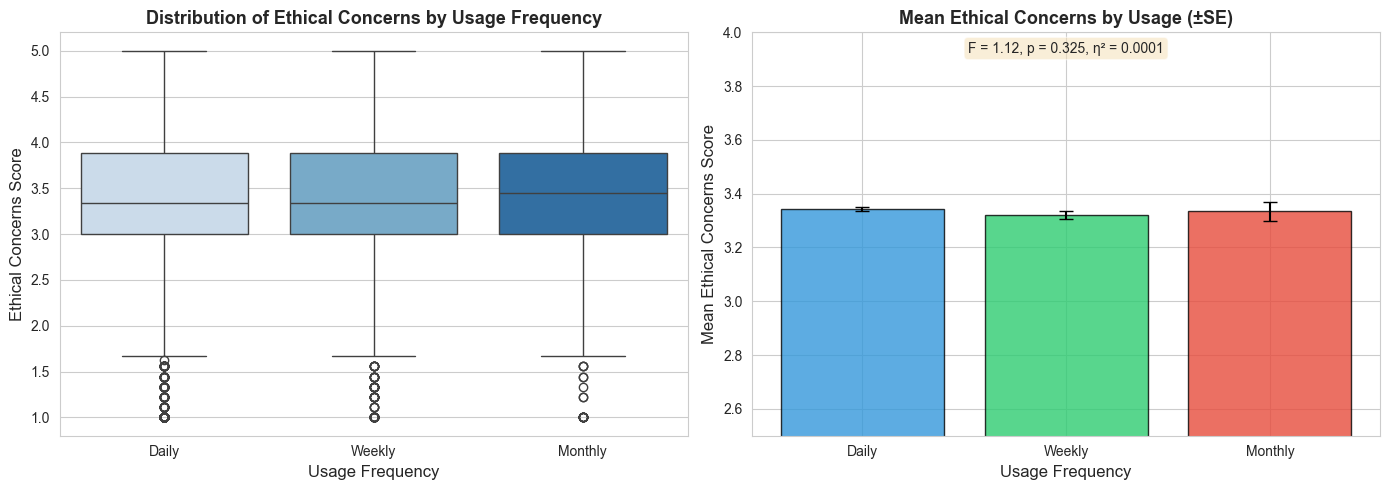

✅ Figure saved


In [7]:
# Visualization: Usage Frequency
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
plot_data = df[df['usage_label'].isin(usage_order)].copy()
sns.boxplot(data=plot_data, x='usage_label', y='ethics_concerns_score', 
            order=usage_order, palette='Blues', ax=axes[0])
axes[0].set_xlabel('Usage Frequency', fontsize=12)
axes[0].set_ylabel('Ethical Concerns Score', fontsize=12)
axes[0].set_title('Distribution of Ethical Concerns by Usage Frequency', fontsize=13, fontweight='bold')

# Bar plot with error bars
desc = usage_results['descriptives']
x_pos = np.arange(len(desc))
bars = axes[1].bar(x_pos, desc['mean'], yerr=desc['se'], capsize=5,
                   color=['#3498db', '#2ecc71', '#e74c3c'], edgecolor='black', alpha=0.8)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(desc.index)
axes[1].set_xlabel('Usage Frequency', fontsize=12)
axes[1].set_ylabel('Mean Ethical Concerns Score', fontsize=12)
axes[1].set_title('Mean Ethical Concerns by Usage (±SE)', fontsize=13, fontweight='bold')
axes[1].set_ylim(2.5, 4.0)

# Add significance annotation
sig_text = f"F = {usage_results['f_stat']:.2f}, p = {usage_results['p_value']:.3f}, η² = {usage_results['eta_squared']:.4f}"
axes[1].text(0.5, 0.95, sig_text, transform=axes[1].transAxes, ha='center', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(fig_dir / 'ethics_by_usage.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Figure saved")

---

## 4. Ethical Concerns by Discipline (Field of Study)

Comparing ethical concerns across four academic disciplines:
- Arts & Humanities
- Social Sciences  
- Applied Sciences
- Natural & Life Sciences

In [8]:
# Run ANOVA for Discipline
discipline_order = ['Arts & Humanities', 'Social Sciences', 'Applied Sciences', 'Natural & Life Sciences']
discipline_results = run_anova_analysis(df, 'discipline', group_order=discipline_order)
print_anova_results(discipline_results, 'Ethical Concerns by Discipline')


ANOVA: Ethical Concerns by Discipline

Descriptive Statistics:
                         count  mean   std    se
discipline                                      
Arts & Humanities         1431 3.269 0.770 0.020
Social Sciences           7179 3.342 0.748 0.009
Applied Sciences          5786 3.357 0.730 0.010
Natural & Life Sciences   1730 3.318 0.739 0.018

Levene's Test for Homogeneity of Variance:
  W = 0.6401, p = 0.5891
  ✅ Equal variances assumption met

One-Way ANOVA:
  F = 5.8255
  p = 5.6627e-04
  ✅ Highly significant (p < 0.001)

Effect Size:
  η² = 0.0011 (Negligible effect)

Total N = 16,126


In [9]:
# Post-hoc tests for Discipline
if discipline_results['p_value'] < 0.05:
    posthoc_disc, bonf_alpha = run_posthoc_tests(df, 'discipline', groups=discipline_order)
    print("\nPost-hoc Pairwise Comparisons:")
    print(f"(Bonferroni-corrected α = {bonf_alpha:.4f})")
    print(posthoc_disc.to_string(index=False))
else:
    print("\nPost-hoc tests not performed (ANOVA not significant)")


Post-hoc Pairwise Comparisons:
(Bonferroni-corrected α = 0.0083)
                                  Comparison      t     p  p_adj  Cohen's d Sig Sig_Bonf
        Arts & Humanities vs Social Sciences -3.347 0.001  0.005     -0.097 ***        *
       Arts & Humanities vs Applied Sciences -4.027 0.000  0.000     -0.119 ***        *
Arts & Humanities vs Natural & Life Sciences -1.824 0.068  0.410     -0.065  ns       ns
         Social Sciences vs Applied Sciences -1.142 0.254  1.000     -0.020  ns       ns
  Social Sciences vs Natural & Life Sciences  1.187 0.235  1.000      0.032  ns       ns
 Applied Sciences vs Natural & Life Sciences  1.926 0.054  0.325      0.053  ns       ns


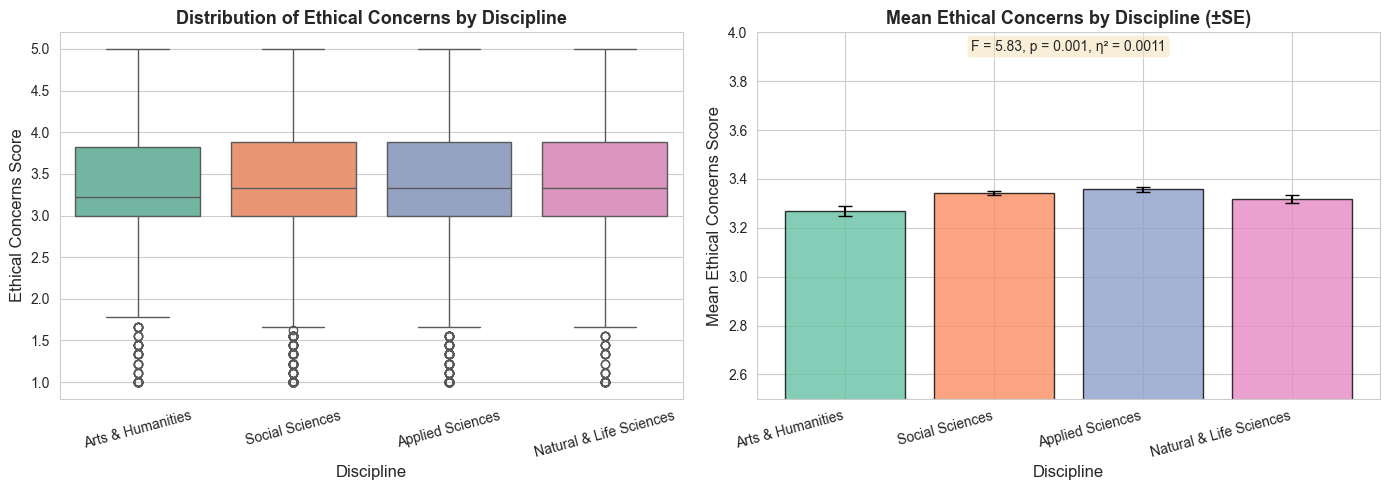

✅ Figure saved


In [10]:
# Visualization: Discipline
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
plot_data = df[df['discipline'].isin(discipline_order)].copy()
sns.boxplot(data=plot_data, x='discipline', y='ethics_concerns_score', 
            order=discipline_order, palette='Set2', ax=axes[0])
axes[0].set_xlabel('Discipline', fontsize=12)
axes[0].set_ylabel('Ethical Concerns Score', fontsize=12)
axes[0].set_title('Distribution of Ethical Concerns by Discipline', fontsize=13, fontweight='bold')
axes[0].tick_params(axis='x', rotation=15)

# Bar plot with error bars
desc = discipline_results['descriptives']
x_pos = np.arange(len(desc))
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']
bars = axes[1].bar(x_pos, desc['mean'], yerr=desc['se'], capsize=5,
                   color=colors, edgecolor='black', alpha=0.8)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(desc.index, rotation=15, ha='right')
axes[1].set_xlabel('Discipline', fontsize=12)
axes[1].set_ylabel('Mean Ethical Concerns Score', fontsize=12)
axes[1].set_title('Mean Ethical Concerns by Discipline (±SE)', fontsize=13, fontweight='bold')
axes[1].set_ylim(2.5, 4.0)

# Add significance annotation
sig_text = f"F = {discipline_results['f_stat']:.2f}, p = {discipline_results['p_value']:.3f}, η² = {discipline_results['eta_squared']:.4f}"
axes[1].text(0.5, 0.95, sig_text, transform=axes[1].transAxes, ha='center', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(fig_dir / 'ethics_by_discipline.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Figure saved")

---

## 5. Ethical Concerns by Gender

In [11]:
# Run ANOVA for Gender
gender_order = ['Male', 'Female', 'Other', 'Prefer not to say']
gender_results = run_anova_analysis(df, 'gender', group_order=gender_order)
print_anova_results(gender_results, 'Ethical Concerns by Gender')


ANOVA: Ethical Concerns by Gender

Descriptive Statistics:
                   count  mean   std    se
gender                                    
Male                6385 3.367 0.727 0.009
Female              9712 3.326 0.745 0.008
Other                 63 2.858 1.169 0.147
Prefer not to say    101 3.031 0.845 0.084

Levene's Test for Homogeneity of Variance:
  W = 13.2969, p = 0.0000
  ⚠️ Assumption of equal variances violated (consider Welch's ANOVA)

One-Way ANOVA:
  F = 18.6347
  p = 4.6121e-12
  ✅ Highly significant (p < 0.001)

Effect Size:
  η² = 0.0034 (Negligible effect)

Total N = 16,261


In [12]:
# Note on small sample sizes
desc = gender_results['descriptives']
print("\n⚠️ Note on Sample Sizes:")
for idx in desc.index:
    n = desc.loc[idx, 'count']
    if n < 100:
        print(f"   - '{idx}' has small n = {n:.0f} (interpret with caution)")


⚠️ Note on Sample Sizes:
   - 'Other' has small n = 63 (interpret with caution)


In [13]:
# Post-hoc tests for Gender
if gender_results['p_value'] < 0.05:
    posthoc_gender, bonf_alpha = run_posthoc_tests(df, 'gender', groups=gender_order)
    print("\nPost-hoc Pairwise Comparisons:")
    print(f"(Bonferroni-corrected α = {bonf_alpha:.4f})")
    print(posthoc_gender.to_string(index=False))
else:
    print("\nPost-hoc tests not performed (ANOVA not significant)")


Post-hoc Pairwise Comparisons:
(Bonferroni-corrected α = 0.0083)
                 Comparison      t     p  p_adj  Cohen's d Sig Sig_Bonf
             Male vs Female  3.413 0.001  0.004      0.055 ***        *
              Male vs Other  5.486 0.000  0.000      0.695 ***        *
  Male vs Prefer not to say  4.595 0.000  0.000      0.461 ***        *
            Female vs Other  4.949 0.000  0.000      0.626 ***        *
Female vs Prefer not to say  3.957 0.000  0.000      0.396 ***        *
 Other vs Prefer not to say -1.097 0.274  1.000     -0.176  ns       ns


In [14]:
# Supplementary: Male vs Female comparison (largest groups)
print("\n" + "="*80)
print("SUPPLEMENTARY: Male vs Female Comparison (Primary Groups)")
print("="*80)

male_data = df[df['gender'] == 'Male']['ethics_concerns_score'].dropna()
female_data = df[df['gender'] == 'Female']['ethics_concerns_score'].dropna()

t_stat, p_val = ttest_ind(male_data, female_data)
pooled_std = np.sqrt(((len(male_data)-1)*male_data.std()**2 + (len(female_data)-1)*female_data.std()**2) / 
                     (len(male_data) + len(female_data) - 2))
cohens_d = (male_data.mean() - female_data.mean()) / pooled_std

print(f"\nMale:   M = {male_data.mean():.3f}, SD = {male_data.std():.3f}, N = {len(male_data):,}")
print(f"Female: M = {female_data.mean():.3f}, SD = {female_data.std():.3f}, N = {len(female_data):,}")
print(f"\nIndependent t-test: t = {t_stat:.4f}, p = {p_val:.4f}")
print(f"Effect size: Cohen's d = {cohens_d:.4f}")


SUPPLEMENTARY: Male vs Female Comparison (Primary Groups)

Male:   M = 3.367, SD = 0.727, N = 6,385
Female: M = 3.326, SD = 0.745, N = 9,712

Independent t-test: t = 3.4127, p = 0.0006
Effect size: Cohen's d = 0.0550


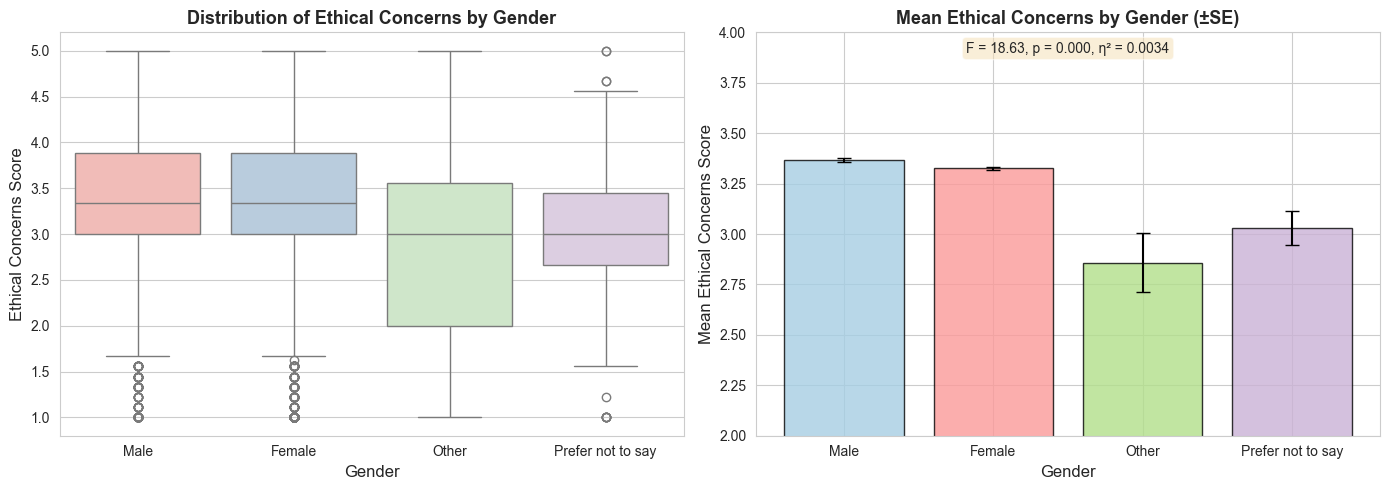

✅ Figure saved


In [15]:
# Visualization: Gender
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
plot_data = df[df['gender'].isin(gender_order)].copy()
sns.boxplot(data=plot_data, x='gender', y='ethics_concerns_score', 
            order=gender_order, palette='Pastel1', ax=axes[0])
axes[0].set_xlabel('Gender', fontsize=12)
axes[0].set_ylabel('Ethical Concerns Score', fontsize=12)
axes[0].set_title('Distribution of Ethical Concerns by Gender', fontsize=13, fontweight='bold')

# Bar plot with error bars
desc = gender_results['descriptives']
x_pos = np.arange(len(desc))
colors = ['#a6cee3', '#fb9a99', '#b2df8a', '#cab2d6']
bars = axes[1].bar(x_pos, desc['mean'], yerr=desc['se'], capsize=5,
                   color=colors, edgecolor='black', alpha=0.8)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(desc.index)
axes[1].set_xlabel('Gender', fontsize=12)
axes[1].set_ylabel('Mean Ethical Concerns Score', fontsize=12)
axes[1].set_title('Mean Ethical Concerns by Gender (±SE)', fontsize=13, fontweight='bold')
axes[1].set_ylim(2.0, 4.0)

# Add significance annotation
sig_text = f"F = {gender_results['f_stat']:.2f}, p = {gender_results['p_value']:.3f}, η² = {gender_results['eta_squared']:.4f}"
axes[1].text(0.5, 0.95, sig_text, transform=axes[1].transAxes, ha='center', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(fig_dir / 'ethics_by_gender.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Figure saved")

---

## 6. Ethical Concerns by Age Group

In [16]:
# Run ANOVA for Age Group
age_order = ['18-21', '22-25', '26-30', '31+']
age_results = run_anova_analysis(df, 'age_group', group_order=age_order)
print_anova_results(age_results, 'Ethical Concerns by Age Group')


ANOVA: Ethical Concerns by Age Group

Descriptive Statistics:
           count  mean   std    se
age_group                         
18-21       8716 3.324 0.732 0.008
22-25       4915 3.354 0.746 0.011
26-30       1305 3.355 0.763 0.021
31+         1320 3.360 0.771 0.021

Levene's Test for Homogeneity of Variance:
  W = 2.6146, p = 0.0494
  ⚠️ Assumption of equal variances violated (consider Welch's ANOVA)

One-Way ANOVA:
  F = 2.4041
  p = 6.5475e-02
  ❌ Not significant (p ≥ 0.05)

Effect Size:
  η² = 0.0004 (Negligible effect)

Total N = 16,256


In [17]:
# Post-hoc tests for Age
if age_results['p_value'] < 0.05:
    posthoc_age, bonf_alpha = run_posthoc_tests(df, 'age_group', groups=age_order)
    print("\nPost-hoc Pairwise Comparisons:")
    print(f"(Bonferroni-corrected α = {bonf_alpha:.4f})")
    print(posthoc_age.to_string(index=False))
else:
    print("\nPost-hoc tests not performed (ANOVA not significant)")


Post-hoc tests not performed (ANOVA not significant)


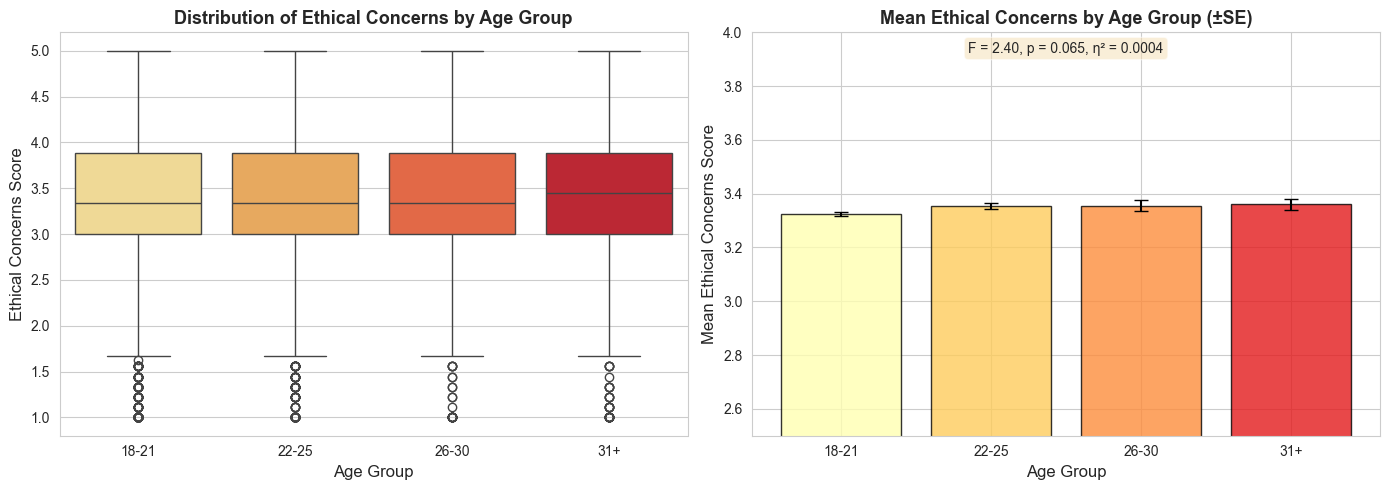

✅ Figure saved


In [18]:
# Visualization: Age Group
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
plot_data = df[df['age_group'].isin(age_order)].copy()
sns.boxplot(data=plot_data, x='age_group', y='ethics_concerns_score', 
            order=age_order, palette='YlOrRd', ax=axes[0])
axes[0].set_xlabel('Age Group', fontsize=12)
axes[0].set_ylabel('Ethical Concerns Score', fontsize=12)
axes[0].set_title('Distribution of Ethical Concerns by Age Group', fontsize=13, fontweight='bold')

# Bar plot with error bars
desc = age_results['descriptives']
x_pos = np.arange(len(desc))
colors = ['#ffffb2', '#fecc5c', '#fd8d3c', '#e31a1c']
bars = axes[1].bar(x_pos, desc['mean'], yerr=desc['se'], capsize=5,
                   color=colors, edgecolor='black', alpha=0.8)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(desc.index)
axes[1].set_xlabel('Age Group', fontsize=12)
axes[1].set_ylabel('Mean Ethical Concerns Score', fontsize=12)
axes[1].set_title('Mean Ethical Concerns by Age Group (±SE)', fontsize=13, fontweight='bold')
axes[1].set_ylim(2.5, 4.0)

# Add significance annotation
sig_text = f"F = {age_results['f_stat']:.2f}, p = {age_results['p_value']:.3f}, η² = {age_results['eta_squared']:.4f}"
axes[1].text(0.5, 0.95, sig_text, transform=axes[1].transAxes, ha='center', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(fig_dir / 'ethics_by_age.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Figure saved")

---

## 7. Ethical Concerns by Study Level

In [19]:
# Run ANOVA for Study Level
level_order = ['Undergraduate', 'Postgraduate/Masters', 'Doctoral']
level_results = run_anova_analysis(df, 'study_level', group_order=level_order)
print_anova_results(level_results, 'Ethical Concerns by Study Level')


ANOVA: Ethical Concerns by Study Level

Descriptive Statistics:
                      count  mean   std    se
study_level                                  
Undergraduate         12576 3.343 0.738 0.007
Postgraduate/Masters   3079 3.321 0.757 0.014
Doctoral                513 3.334 0.776 0.034

Levene's Test for Homogeneity of Variance:
  W = 1.4469, p = 0.2353
  ✅ Equal variances assumption met

One-Way ANOVA:
  F = 1.1240
  p = 3.2501e-01
  ❌ Not significant (p ≥ 0.05)

Effect Size:
  η² = 0.0001 (Negligible effect)

Total N = 16,168


In [20]:
# Post-hoc tests for Study Level
if level_results['p_value'] < 0.05:
    posthoc_level, bonf_alpha = run_posthoc_tests(df, 'study_level', groups=level_order)
    print("\nPost-hoc Pairwise Comparisons:")
    print(f"(Bonferroni-corrected α = {bonf_alpha:.4f})")
    print(posthoc_level.to_string(index=False))
else:
    print("\nPost-hoc tests not performed (ANOVA not significant)")


Post-hoc tests not performed (ANOVA not significant)


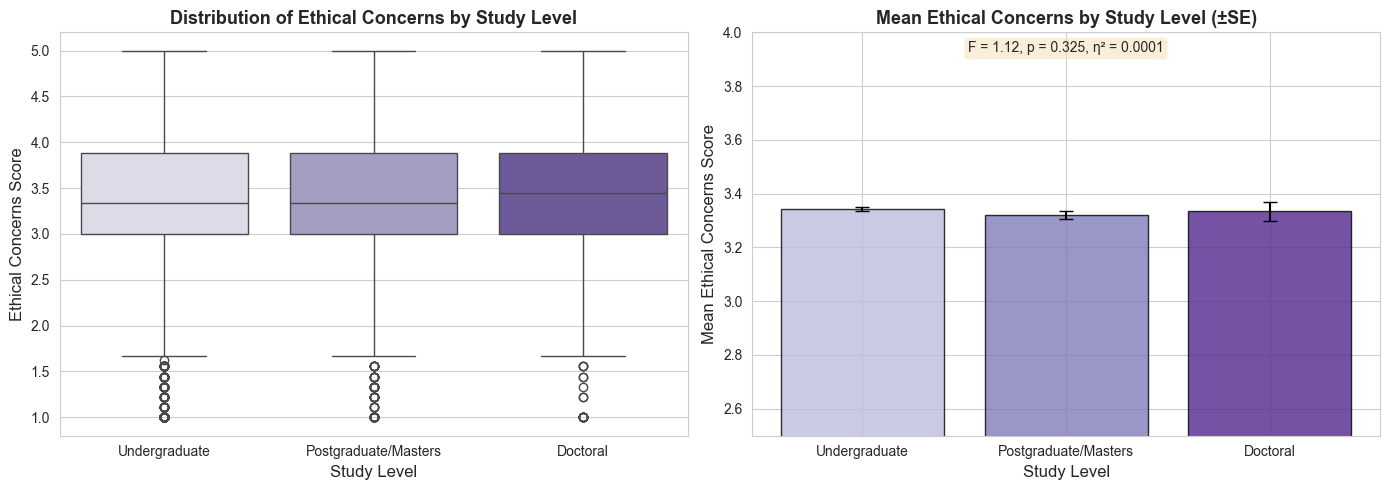

✅ Figure saved


In [21]:
# Visualization: Study Level
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
plot_data = df[df['study_level'].isin(level_order)].copy()
sns.boxplot(data=plot_data, x='study_level', y='ethics_concerns_score', 
            order=level_order, palette='Purples', ax=axes[0])
axes[0].set_xlabel('Study Level', fontsize=12)
axes[0].set_ylabel('Ethical Concerns Score', fontsize=12)
axes[0].set_title('Distribution of Ethical Concerns by Study Level', fontsize=13, fontweight='bold')

# Bar plot with error bars
desc = level_results['descriptives']
x_pos = np.arange(len(desc))
colors = ['#bcbddc', '#807dba', '#54278f']
bars = axes[1].bar(x_pos, desc['mean'], yerr=desc['se'], capsize=5,
                   color=colors, edgecolor='black', alpha=0.8)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(desc.index)
axes[1].set_xlabel('Study Level', fontsize=12)
axes[1].set_ylabel('Mean Ethical Concerns Score', fontsize=12)
axes[1].set_title('Mean Ethical Concerns by Study Level (±SE)', fontsize=13, fontweight='bold')
axes[1].set_ylim(2.5, 4.0)

# Add significance annotation
sig_text = f"F = {level_results['f_stat']:.2f}, p = {level_results['p_value']:.3f}, η² = {level_results['eta_squared']:.4f}"
axes[1].text(0.5, 0.95, sig_text, transform=axes[1].transAxes, ha='center', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(fig_dir / 'ethics_by_study_level.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Figure saved")

---

## 8. Ethical Concerns by Region/Language

In [22]:
# Run ANOVA for Region
region_order = ['English', 'Spanish', 'Arabic', 'Turkish', 'Italian', 'Japanese', 'Hebrew']
region_results = run_anova_analysis(df, 'region', group_order=region_order)
print_anova_results(region_results, 'Ethical Concerns by Region/Language')


ANOVA: Ethical Concerns by Region/Language

Descriptive Statistics:
          count  mean   std    se
region                           
English    9709 3.339 0.745 0.008
Spanish    2855 3.252 0.723 0.014
Arabic     1540 3.402 0.720 0.018
Turkish    1062 3.604 0.674 0.021
Italian     899 3.268 0.755 0.025
Japanese    148 2.793 0.863 0.071
Hebrew      100 3.409 0.770 0.077

Levene's Test for Homogeneity of Variance:
  W = 7.3544, p = 0.0000
  ⚠️ Assumption of equal variances violated (consider Welch's ANOVA)

One-Way ANOVA:
  F = 46.5045
  p = 7.9876e-57
  ✅ Highly significant (p < 0.001)

Effect Size:
  η² = 0.0168 (Small effect)

Total N = 16,313


In [23]:
# Post-hoc tests for Region
if region_results['p_value'] < 0.05:
    posthoc_region, bonf_alpha = run_posthoc_tests(df, 'region', groups=region_order)
    print("\nPost-hoc Pairwise Comparisons:")
    print(f"(Bonferroni-corrected α = {bonf_alpha:.4f})")
    print("\nTop 10 most significant comparisons:")
    print(posthoc_region.sort_values('p').head(10).to_string(index=False))


Post-hoc Pairwise Comparisons:
(Bonferroni-corrected α = 0.0024)

Top 10 most significant comparisons:
         Comparison       t     p  p_adj  Cohen's d Sig Sig_Bonf
 Spanish vs Turkish -13.780 0.000  0.000     -0.495 ***        *
Turkish vs Japanese  13.206 0.000  0.000      1.159 ***        *
 English vs Turkish -11.093 0.000  0.000     -0.359 ***        *
 Turkish vs Italian  10.397 0.000  0.000      0.471 ***        *
 Arabic vs Japanese   9.646 0.000  0.000      0.830 ***        *
English vs Japanese   8.829 0.000  0.000      0.731 ***        *
Spanish vs Japanese   7.456 0.000  0.000      0.629 ***        *
  Arabic vs Turkish  -7.208 0.000  0.000     -0.287 ***        *
Italian vs Japanese   6.945 0.000  0.000      0.616 ***        *
  Spanish vs Arabic  -6.569 0.000  0.000     -0.208 ***        *


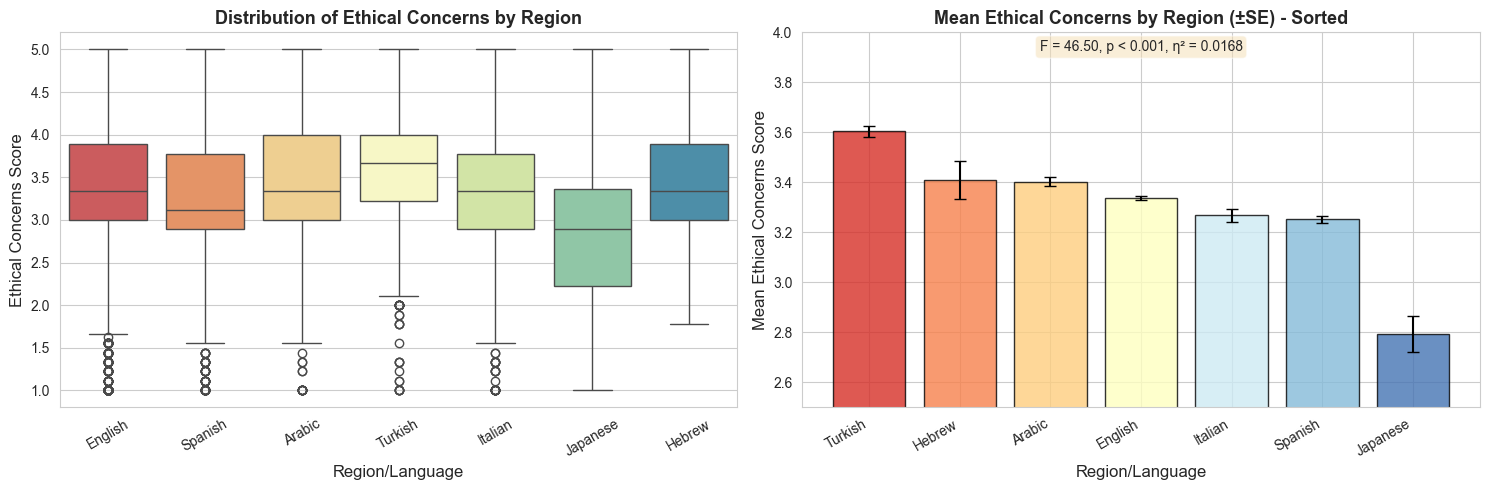

✅ Figure saved


In [24]:
# Visualization: Region
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Box plot
plot_data = df[df['region'].isin(region_order)].copy()
sns.boxplot(data=plot_data, x='region', y='ethics_concerns_score', 
            order=region_order, palette='Spectral', ax=axes[0])
axes[0].set_xlabel('Region/Language', fontsize=12)
axes[0].set_ylabel('Ethical Concerns Score', fontsize=12)
axes[0].set_title('Distribution of Ethical Concerns by Region', fontsize=13, fontweight='bold')
axes[0].tick_params(axis='x', rotation=30)

# Bar plot - sorted by mean
desc = region_results['descriptives'].sort_values('mean', ascending=False)
x_pos = np.arange(len(desc))
colors = plt.cm.RdYlBu(np.linspace(0.1, 0.9, len(desc)))
bars = axes[1].bar(x_pos, desc['mean'], yerr=desc['se'], capsize=4,
                   color=colors, edgecolor='black', alpha=0.8)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(desc.index, rotation=30, ha='right')
axes[1].set_xlabel('Region/Language', fontsize=12)
axes[1].set_ylabel('Mean Ethical Concerns Score', fontsize=12)
axes[1].set_title('Mean Ethical Concerns by Region (±SE) - Sorted', fontsize=13, fontweight='bold')
axes[1].set_ylim(2.5, 4.0)

# Add significance annotation
sig_text = f"F = {region_results['f_stat']:.2f}, p < 0.001, η² = {region_results['eta_squared']:.4f}"
axes[1].text(0.5, 0.95, sig_text, transform=axes[1].transAxes, ha='center', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(fig_dir / 'ethics_by_region.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Figure saved")

---

## 9. Summary of All Group Comparisons

In [25]:
# Create comprehensive summary table
summary_data = [
    {
        'Grouping Variable': 'Usage Frequency',
        'Groups': 'Daily, Weekly, Monthly',
        'N': usage_results['n_total'],
        'F': usage_results['f_stat'],
        'p-value': usage_results['p_value'],
        'η²': usage_results['eta_squared'],
        'Effect Size': usage_results['effect_interpretation'],
        'Significant': 'Yes' if usage_results['p_value'] < 0.05 else 'No'
    },
    {
        'Grouping Variable': 'Discipline',
        'Groups': '4 fields of study',
        'N': discipline_results['n_total'],
        'F': discipline_results['f_stat'],
        'p-value': discipline_results['p_value'],
        'η²': discipline_results['eta_squared'],
        'Effect Size': discipline_results['effect_interpretation'],
        'Significant': 'Yes' if discipline_results['p_value'] < 0.05 else 'No'
    },
    {
        'Grouping Variable': 'Gender',
        'Groups': 'Male, Female, Other, Prefer not to say',
        'N': gender_results['n_total'],
        'F': gender_results['f_stat'],
        'p-value': gender_results['p_value'],
        'η²': gender_results['eta_squared'],
        'Effect Size': gender_results['effect_interpretation'],
        'Significant': 'Yes' if gender_results['p_value'] < 0.05 else 'No'
    },
    {
        'Grouping Variable': 'Age Group',
        'Groups': '18-21, 22-25, 26-30, 31+',
        'N': age_results['n_total'],
        'F': age_results['f_stat'],
        'p-value': age_results['p_value'],
        'η²': age_results['eta_squared'],
        'Effect Size': age_results['effect_interpretation'],
        'Significant': 'Yes' if age_results['p_value'] < 0.05 else 'No'
    },
    {
        'Grouping Variable': 'Study Level',
        'Groups': 'Undergrad, Postgrad, Doctoral',
        'N': level_results['n_total'],
        'F': level_results['f_stat'],
        'p-value': level_results['p_value'],
        'η²': level_results['eta_squared'],
        'Effect Size': level_results['effect_interpretation'],
        'Significant': 'Yes' if level_results['p_value'] < 0.05 else 'No'
    },
    {
        'Grouping Variable': 'Region/Language',
        'Groups': '7 language groups',
        'N': region_results['n_total'],
        'F': region_results['f_stat'],
        'p-value': region_results['p_value'],
        'η²': region_results['eta_squared'],
        'Effect Size': region_results['effect_interpretation'],
        'Significant': 'Yes' if region_results['p_value'] < 0.05 else 'No'
    }
]

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*100)
print("SUMMARY OF ALL GROUP COMPARISONS (RQ2)")
print("="*100)
print("\nDependent Variable: Ethical Concerns Score")
print("Method: One-Way ANOVA\n")
print(summary_df.to_string(index=False))

# Save summary
summary_df.to_csv(output_dir / 'anova_summary_all.csv', index=False)
print("\n✅ Summary saved to results/tables/anova_summary_all.csv")


SUMMARY OF ALL GROUP COMPARISONS (RQ2)

Dependent Variable: Ethical Concerns Score
Method: One-Way ANOVA

Grouping Variable                                 Groups     N      F  p-value    η² Effect Size Significant
  Usage Frequency                 Daily, Weekly, Monthly 16168  1.124    0.325 0.000  Negligible          No
       Discipline                      4 fields of study 16126  5.826    0.001 0.001  Negligible         Yes
           Gender Male, Female, Other, Prefer not to say 16261 18.635    0.000 0.003  Negligible         Yes
        Age Group               18-21, 22-25, 26-30, 31+ 16256  2.404    0.065 0.000  Negligible          No
      Study Level          Undergrad, Postgrad, Doctoral 16168  1.124    0.325 0.000  Negligible          No
  Region/Language                      7 language groups 16313 46.505    0.000 0.017       Small         Yes

✅ Summary saved to results/tables/anova_summary_all.csv


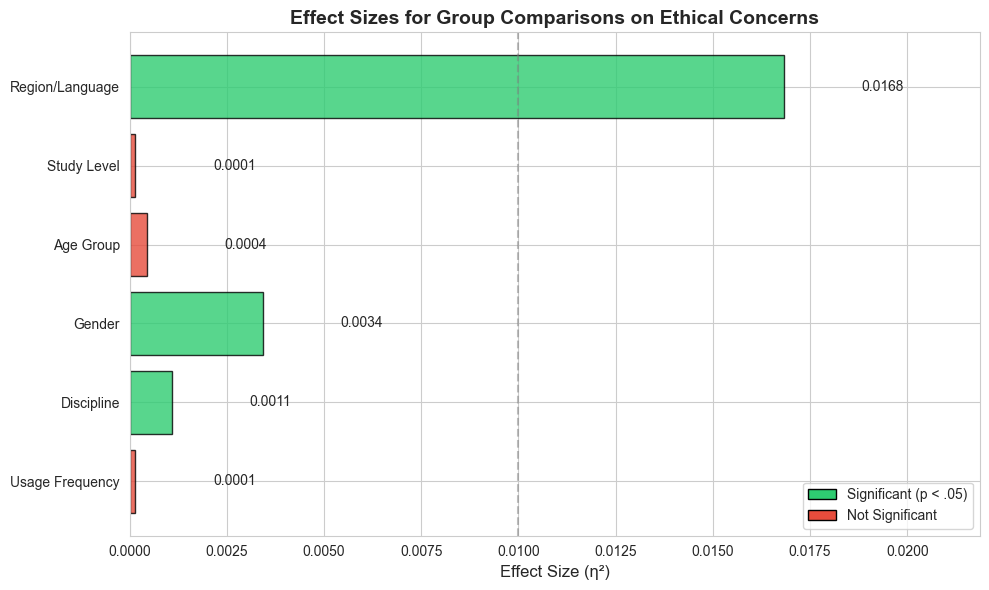

✅ Figure saved


In [26]:
# Visual summary: Forest plot of effect sizes
fig, ax = plt.subplots(figsize=(10, 6))

variables = summary_df['Grouping Variable'].values
eta_sq = summary_df['η²'].values
significant = summary_df['Significant'].values

y_pos = np.arange(len(variables))
colors = ['#2ecc71' if s == 'Yes' else '#e74c3c' for s in significant]

bars = ax.barh(y_pos, eta_sq, color=colors, edgecolor='black', alpha=0.8)
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.set_xlabel('Effect Size (η²)', fontsize=12)
ax.set_title('Effect Sizes for Group Comparisons on Ethical Concerns', fontsize=14, fontweight='bold')

# Add reference lines for effect size thresholds
ax.axvline(x=0.01, color='gray', linestyle='--', alpha=0.5, label='Small (0.01)')
ax.axvline(x=0.06, color='gray', linestyle='-.', alpha=0.5, label='Medium (0.06)')
ax.axvline(x=0.14, color='gray', linestyle=':', alpha=0.5, label='Large (0.14)')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, eta_sq)):
    ax.text(val + 0.002, bar.get_y() + bar.get_height()/2, f'{val:.4f}', 
            va='center', fontsize=10)

ax.legend(loc='lower right')
ax.set_xlim(0, max(eta_sq) * 1.3)

# Add legend for significance
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#2ecc71', edgecolor='black', label='Significant (p < .05)'),
                   Patch(facecolor='#e74c3c', edgecolor='black', label='Not Significant')]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig(fig_dir / 'effect_sizes_summary.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Figure saved")

---

## 10. Key Findings and Interpretation

In [27]:
print("\n" + "="*80)
print("KEY FINDINGS FOR RQ2")
print("="*80)
print("\nResearch Question: How do ethical concerns about ChatGPT vary by usage")
print("frequency, discipline, and demographics?")
print("\n" + "-"*80)

# Determine which variables showed significant differences
sig_vars = summary_df[summary_df['Significant'] == 'Yes']['Grouping Variable'].tolist()
nonsig_vars = summary_df[summary_df['Significant'] == 'No']['Grouping Variable'].tolist()

print("\n📊 SIGNIFICANT DIFFERENCES FOUND:")
if sig_vars:
    for var in sig_vars:
        row = summary_df[summary_df['Grouping Variable'] == var].iloc[0]
        print(f"\n   {var}:")
        print(f"      F = {row['F']:.2f}, p = {row['p-value']:.4f}, η² = {row['η²']:.4f} ({row['Effect Size']} effect)")
else:
    print("   None")

print("\n❌ NO SIGNIFICANT DIFFERENCES:")
if nonsig_vars:
    for var in nonsig_vars:
        row = summary_df[summary_df['Grouping Variable'] == var].iloc[0]
        print(f"   {var}: F = {row['F']:.2f}, p = {row['p-value']:.4f}")
else:
    print("   All variables showed significant differences")

print("\n" + "-"*80)
print("\n📈 LARGEST EFFECT SIZES:")
sorted_summary = summary_df.sort_values('η²', ascending=False)
for i, row in sorted_summary.head(3).iterrows():
    print(f"   {row['Grouping Variable']}: η² = {row['η²']:.4f} ({row['Effect Size']})")

print("\n" + "-"*80)
print("\n🔍 INTERPRETATION:")

# Region-specific finding
if 'Region/Language' in sig_vars:
    region_desc = region_results['descriptives'].sort_values('mean')
    print(f"\n   REGION: Substantial cross-cultural variation exists.")
    print(f"      - Highest concerns: {region_desc.index[-1]} (M = {region_desc['mean'].iloc[-1]:.2f})")
    print(f"      - Lowest concerns: {region_desc.index[0]} (M = {region_desc['mean'].iloc[0]:.2f})")

# Gender finding
if 'Gender' in sig_vars:
    print(f"\n   GENDER: Significant differences exist, though effect size is small.")
    print(f"      - Note: 'Other' category has small sample size (n < 100)")

# Usage finding
if 'Usage Frequency' in nonsig_vars:
    print(f"\n   USAGE FREQUENCY: No significant difference in ethical concerns")
    print(f"      - Daily, Weekly, and Monthly users report similar concern levels")

print("\n" + "="*80)


KEY FINDINGS FOR RQ2

Research Question: How do ethical concerns about ChatGPT vary by usage
frequency, discipline, and demographics?

--------------------------------------------------------------------------------

📊 SIGNIFICANT DIFFERENCES FOUND:

   Discipline:
      F = 5.83, p = 0.0006, η² = 0.0011 (Negligible effect)

   Gender:
      F = 18.63, p = 0.0000, η² = 0.0034 (Negligible effect)

   Region/Language:
      F = 46.50, p = 0.0000, η² = 0.0168 (Small effect)

❌ NO SIGNIFICANT DIFFERENCES:
   Usage Frequency: F = 1.12, p = 0.3250
   Age Group: F = 2.40, p = 0.0655
   Study Level: F = 1.12, p = 0.3250

--------------------------------------------------------------------------------

📈 LARGEST EFFECT SIZES:
   Region/Language: η² = 0.0168 (Small)
   Gender: η² = 0.0034 (Negligible)
   Discipline: η² = 0.0011 (Negligible)

--------------------------------------------------------------------------------

🔍 INTERPRETATION:

   REGION: Substantial cross-cultural variation exists

In [28]:
print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print("""
Files Created:
─────────────────────────────────────────────────────────────────────
Tables:
  ✅ results/tables/anova_summary_all.csv

Figures:
  ✅ results/figures/ethics_by_usage.png
  ✅ results/figures/ethics_by_discipline.png
  ✅ results/figures/ethics_by_gender.png
  ✅ results/figures/ethics_by_age.png
  ✅ results/figures/ethics_by_study_level.png
  ✅ results/figures/ethics_by_region.png
  ✅ results/figures/effect_sizes_summary.png
─────────────────────────────────────────────────────────────────────
""")


ANALYSIS COMPLETE

Files Created:
─────────────────────────────────────────────────────────────────────
Tables:
  ✅ results/tables/anova_summary_all.csv

Figures:
  ✅ results/figures/ethics_by_usage.png
  ✅ results/figures/ethics_by_discipline.png
  ✅ results/figures/ethics_by_gender.png
  ✅ results/figures/ethics_by_age.png
  ✅ results/figures/ethics_by_study_level.png
  ✅ results/figures/ethics_by_region.png
  ✅ results/figures/effect_sizes_summary.png
─────────────────────────────────────────────────────────────────────



RQ4: Do these relationships differ across disciplines?

In [29]:
def classify_discipline(text):
    if not isinstance(text, str):
        return 'Other'
    text = text.lower()
    if any(x in text for x in ['busin', 'econ', 'manag', 'market', 'financ', 'account', 'admin']):
        return 'Business/Econ'
    elif any(x in text for x in ['engin', 'tech', 'comput', 'mechan', 'electr', 'civil', 'info', 'data']):
        return 'STEM'
    elif any(x in text for x in ['medic', 'health', 'nurs', 'pharma', 'bio', 'dent']):
        return 'Health/Medicine'
    elif any(x in text for x in ['art', 'design', 'music', 'human', 'hist', 'lang', 'lit']):
        return 'Arts/Humanities'
    elif any(x in text for x in ['law', 'legal', 'jur']):
        return 'Law'
    elif any(x in text for x in ['educ', 'teach', 'pedag']):
        return 'Education'
    elif any(x in text for x in ['soc', 'psych', 'politic', 'gov']):
        return 'Social Sciences'
    else:
        return 'Other'

df['Discipline_Group'] = df['Q5'].apply(classify_discipline)

In [30]:
score_cols = ['capabilities_score', 'ethics_concerns_score', 'attitudes_score']
results = []

print(f"{'Discipline':<20} | {'Correlation (Cap vs Att)':<25} | {'Count'}")
print("-" * 55)

for disc in df['Discipline_Group'].unique():
    subset = df[df['Discipline_Group'] == disc]
    if len(subset) > 50: # Filter small groups
        corr = subset[score_cols].corr().loc['capabilities_score', 'attitudes_score']
        results.append({'Discipline': disc, 'Correlation': corr})
        print(f"{disc:<20} | {corr:.3f}                     | {len(subset)}")


Discipline           | Correlation (Cap vs Att)  | Count
-------------------------------------------------------
Other                | 0.319                     | 15190
Business/Econ        | 0.381                     | 2010
Arts/Humanities      | 0.039                     | 1367
STEM                 | 0.416                     | 1262
Law                  | 0.371                     | 75
Health/Medicine      | 0.367                     | 1271
Education            | 0.347                     | 1329
Social Sciences      | 0.365                     | 332


In [31]:
score_cols = ['capabilities_score', 'ethics_concerns_score', 'attitudes_score']
results = []

print(f"{'Discipline':<20} | {'Correlation (Cap vs Att)':<25} | {'Count'}")
print("-" * 55)

for disc in df['Discipline_Group'].unique():
    subset = df[df['Discipline_Group'] == disc]
    if len(subset) > 50: # Filter small groups
        corr = subset[score_cols].corr().loc['capabilities_score', 'attitudes_score']
        results.append({'Discipline': disc, 'Correlation': corr})
        print(f"{disc:<20} | {corr:.3f}                     | {len(subset)}")


Discipline           | Correlation (Cap vs Att)  | Count
-------------------------------------------------------
Other                | 0.319                     | 15190
Business/Econ        | 0.381                     | 2010
Arts/Humanities      | 0.039                     | 1367
STEM                 | 0.416                     | 1262
Law                  | 0.371                     | 75
Health/Medicine      | 0.367                     | 1271
Education            | 0.347                     | 1329
Social Sciences      | 0.365                     | 332
